<a href="https://colab.research.google.com/github/Lynxlazy/genomics-data-analysis/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --output-document sratoolkit.tar.gz https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
!tar -vxzf sratoolkit.tar.gz


--2023-03-04 06:43:02--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.11, 2607:f220:41e:250::13, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86400775 (82M) [application/x-gzip]
Saving to: ‘sratoolkit.tar.gz’

sratoolkit.tar.gz   100%[===================>]  82.40M  78.7MB/s    in 1.0s    

2023-03-04 06:43:04 (78.7 MB/s) - ‘sratoolkit.tar.gz’ saved [86400775/86400775]

sratoolkit.3.0.1-ubuntu64/
sratoolkit.3.0.1-ubuntu64/README.md
sratoolkit.3.0.1-ubuntu64/schema/
sratoolkit.3.0.1-ubuntu64/schema/insdc/
sratoolkit.3.0.1-ubuntu64/schema/insdc/sra.vschema
sratoolkit.3.0.1-ubuntu64/schema/insdc/insdc.vschema
sratoolkit.3.0.1-ubuntu64/schema/insdc/seq.vschema
sratoolkit.3.0.1-ubuntu64/schema/align/
sratoolkit.3.0.1-ubuntu64/schema/align/refs

In [ ]:
!export PATH=$PATH:$PWD/sratoolkit.3.0.1-ubuntu64/bin


# 1. Exploring the dataset

In [ ]:
!./sratoolkit.3.0.1-ubuntu64/bin/fasterq-dump SRR292678
!./sratoolkit.3.0.1-ubuntu64/bin/fasterq-dump SRR292862
!./sratoolkit.3.0.1-ubuntu64/bin/fasterq-dump SRR292770

spots read      : 6,111,112
reads read      : 12,222,224
reads written   : 12,222,224
spots read      : 5,102,041
reads read      : 10,204,082
reads written   : 10,204,082
spots read      : 5,102,041
reads read      : 10,204,082
reads written   : 10,204,082


# 2. K-mer profile and genome size estimation


In [ ]:
!sudo apt install jellyfish

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libhts3 libjellyfish-2.0-2
The following NEW packages will be installed:
  jellyfish libhts3 libjellyfish-2.0-2
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 771 kB of archives.
After this operation, 1,727 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 libhts3 amd64 1.10.2-3ubuntu0.1 [350 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libjellyfish-2.0-2 amd64 2.3.0-4build1 [60.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 jellyfish amd64 2.3.0-4build1 [361 kB]
Fetched 771 kB in 1s (892 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf:

In [ ]:
!jellyfish count -m 21 -s 100M -t 10 -C SRR292678_1.fastq


In [ ]:
!jellyfish histo -o mer_counts.histo mer_counts.jf


In [ ]:
!pip install rpy2==3.4.2
%reload_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wc -l mer_counts.histo

1134 mer_counts.histo


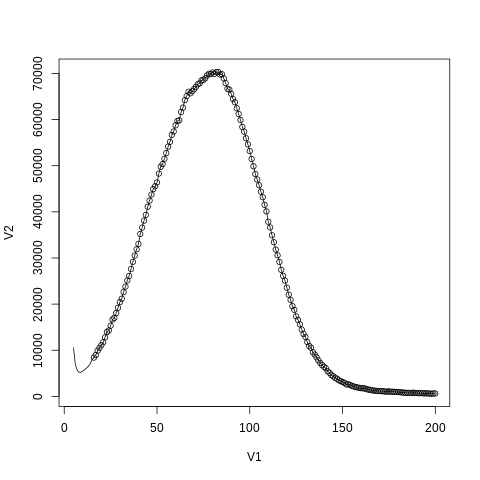

In [ ]:
%%R
mer_counts <- read.table("mer_counts.histo")
plot(mer_counts[5:200,],type="l")
points(mer_counts[16:200,])

In [ ]:
%%R
sum(as.numeric(mer_counts[16:1130,1]*mer_counts[16:1130,2]))



[1] 419940727


In [ ]:
%%R
mer_counts[65:85,]

   V1    V2
65 65 64206
66 66 65108
67 67 66027
68 68 65706
69 69 66165
70 70 66607
71 71 67096
72 72 67648
73 73 67841
74 74 68492
75 75 68619
76 76 68949
77 77 69577
78 78 69925
79 79 69894
80 80 70222
81 81 69926
82 82 70279
83 83 70337
84 84 69762
85 85 69835


In [ ]:
%%R
sum(as.numeric(mer_counts[16:1134,1]*mer_counts[16:1134,2]))/80


[1] 5249408


In [ ]:
%%R
sum(as.numeric(mer_counts[10:150,1]*mer_counts[10:150,2]))/80


[1] 4926079


In [ ]:
%%R
sum(as.numeric(mer_counts[10:150,1]*mer_counts[10:150,2]))/sum(as.numeric(mer_counts[16:1134,1]*mer_counts[16:1134,2]))

[1] 0.9384066


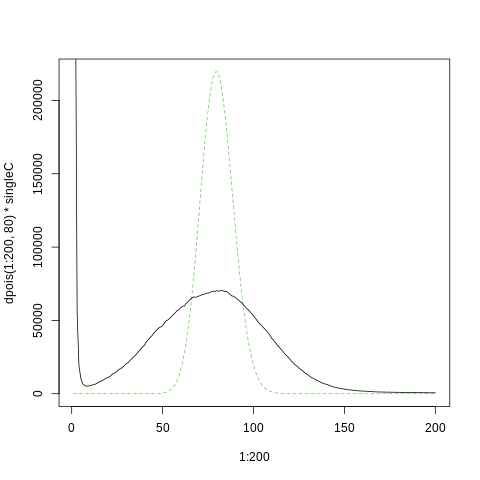

In [ ]:
%%R
singleC <- sum(as.numeric(mer_counts[10:150,1]*mer_counts[10:150,2]))/80
plot(1:200,dpois(1:200, 80)*singleC, type = "l", col=3, lty=2)
lines(mer_counts[1:200,],type="l")

# 3. Assembling E. coli X genome from paired reads

In [ ]:
!apt -y install spades

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  bamtools bwa cwltool fonts-glyphicons-halflings libbamtools2.5.1 libc-ares2
  libhat-trie0 libjs-bootstrap libnlopt0 libnode64 libssw0 nodejs nodejs-doc
  python3-atomicwrites python3-attr python3-bs4 python3-cachecontrol
  python3-coloredlogs python3-dateutil python3-decorator python3-html5lib
  python3-humanfriendly python3-importlib-metadata python3-isodate
  python3-joblib python3-lockfile python3-lxml python3-mistune
  python3-more-itertools python3-msgpack python3-mypy-extensions
  python3-networkx python3-packaging python3-pluggy python3-prov
  python3-psutil python3-py python3-pyparsing python3-pytest python3-rdflib
  python3-rdflib-jsonld python3-ruamel.yaml python3-schema-salad
  python3-shellescape python3-simplejson python3-soupsieve
  python3-sparqlwrapper python3-typing-extensions python3-wcwidth
  python3-webencodings pyth

In [ ]:
!spades -1 SRR292678_1.fastq -2 SRR292678_2.fastq -o output

/bin/bash: spades: command not found


In [ ]:
!pip install quast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 14.2 MB/s eta 0:00:00
  Created wheel for quast: filename=quast-5.2.0-py3-none-any.whl size=31206447 sha256=281f73ed867a5bfd27bbaa73b629be2644c3b00567c0bd0ef551a5930cb65a97
  Stored in directory: /root/.cache/pip/wheels/79/fe/84/429b22fc6184f0807dfdcb67bdf0d95441b3415bce83219ad2
Successfully built quast


In [ ]:
!quast.py output/contigs.fasta

/usr/local/bin/quast.py output/contigs.fasta

Version: 5.2.0

System information:
  OS: Linux-5.10.147+-x86_64-with-glibc2.29 (linux_64)
  Python version: 3.8.10
  CPUs number: 2

Started: 2023-03-03 11:27:07

Logging to /content/quast_results/results_2023_03_03_11_27_07/quast.log
NOTICE: Maximum number of threads is set to 1 (use --threads option to set it manually)

CWD: /content
Main parameters: 
  MODE: default, threads: 1, min contig length: 500, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Contigs:
  Pre-processing...
  output/contigs.fasta ==> contigs

2023-03-03 11:27:08
Running Basic statistics processor...
  Contig files: 
    contigs
  Calculating N50 and L50...
    contigs, N50 = 105346, L50 = 15, auN = 127832.1, Total length = 5245723, GC % = 50.53, # N's per 100 kbp =  0.00
  Drawing Nx plot...
    saved to /content/quast_results/results_2023_03_03_11_27_07/basic_stats/Nx_

In [ ]:
!cat quast_results/latest/report.txt

All statistics are based on contigs of size >= 500 bp, unless otherwise noted (e.g., "# contigs (>= 0 bp)" and "Total length (>= 0 bp)" include all contigs).

Assembly                    contigs 
# contigs (>= 0 bp)         510     
# contigs (>= 1000 bp)      147     
# contigs (>= 5000 bp)      82      
# contigs (>= 10000 bp)     69      
# contigs (>= 25000 bp)     51      
# contigs (>= 50000 bp)     33      
Total length (>= 0 bp)      5316686 
Total length (>= 1000 bp)   5206945 
Total length (>= 5000 bp)   5043449 
Total length (>= 10000 bp)  4953165 
Total length (>= 25000 bp)  4664641 
Total length (>= 50000 bp)  4002075 
# contigs                   201     
Largest contig              300784  
Total length                5245723 
GC (%)                      50.53   
N50                         105346  
N90                         21421   
auN                         127832.1
L50                         15      
L90                         54      
# N's per 100 kbp          

# 3a. Effect of read correction.

In [14]:
!unzip spades_output.zip

Archive:  spades_output.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of spades_output.zip or
        spades_output.zip.zip, and cannot find spades_output.zip.ZIP, period.


# 4. Impact of reads with large insert size

In [ ]:
!spades.py --pe1-1 SRR292678_1.fastq --pe1-2 SRR292678_2.fastq \
    --mp1-1 SRR292770_1.fastq --mp1-2 SRR292770_2.fastq \
    --mp2-1 SRR292862_1.fastq --mp2-2 SRR292862_2.fastq \
    -o spades_output

Command line: /usr/lib/spades/bin/spades.py	--pe1-1	/content/SRR292678_1.fastq	--pe1-2	/content/SRR292678_2.fastq	--mp1-1	/content/SRR292770_1.fastq	--mp1-2	/content/SRR292770_2.fastq	--mp2-1	/content/SRR292862_1.fastq	--mp2-2	/content/SRR292862_2.fastq	-o	/content/spades_output	

System information:
  SPAdes version: 3.13.1
  Python version: 3.8.10
  OS: Linux-5.10.147+-x86_64-with-glibc2.29

Output dir: /content/spades_output
Mode: read error correction and assembling
Debug mode is turned OFF

Dataset parameters:
  Multi-cell mode (you should set '--sc' flag if input data was obtained with MDA (single-cell) technology or --meta flag if processing metagenomic dataset)
  Reads:
    Library number: 1, library type: mate-pairs
      orientation: rf
      left reads: ['/content/SRR292770_1.fastq']
      right reads: ['/content/SRR292770_2.fastq']
      interlaced reads: not specified
      single reads: not specified
      merged reads: not specified
    Library number: 2, library type: m

In [ ]:
!unzip three_libs_spades_out.zip

Archive:  three_libs_spades_out.zip
   creating: three_libs_spades_out/
  inflating: three_libs_spades_out/PROKKA_03032023.zip  
  inflating: three_libs_spades_out/contigs.fasta.fai  
  inflating: three_libs_spades_out/contigs.fasta  
  inflating: three_libs_spades_out/scaffolds.fasta  
  inflating: three_libs_spades_out/spades.log  
   creating: three_libs_spades_out/PROKKA_03032023/
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.fna.fai  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.log  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.fna  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.gff  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.faa  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.ffn  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.tbl  
  inflating: three_libs_spades_out/PROKKA_03032023/PROKKA_03032023.fsa  
  inflating: three_libs_

In [ ]:
!quast.py three_libs_spades_out/contigs.fasta

/usr/local/bin/quast.py three_libs_spades_out/contigs.fasta

Version: 5.2.0

System information:
  OS: Linux-5.10.147+-x86_64-with-glibc2.29 (linux_64)
  Python version: 3.8.10
  CPUs number: 2

Started: 2023-03-04 06:54:21

Logging to /content/quast_results/results_2023_03_04_06_54_21/quast.log
NOTICE: Maximum number of threads is set to 1 (use --threads option to set it manually)

CWD: /content
Main parameters: 
  MODE: default, threads: 1, min contig length: 500, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Contigs:
  Pre-processing...
  three_libs_spades_out/contigs.fasta ==> contigs

2023-03-04 06:54:22
Running Basic statistics processor...
  Contig files: 
    contigs
  Calculating N50 and L50...
    contigs, N50 = 335515, L50 = 6, auN = 319603.4, Total length = 5350156, GC % = 50.59, # N's per 100 kbp =  0.00
  Drawing Nx plot...
    saved to /content/quast_results/results_2023_0

In [ ]:
!cat quast_results/latest/report.txt

All statistics are based on contigs of size >= 500 bp, unless otherwise noted (e.g., "# contigs (>= 0 bp)" and "Total length (>= 0 bp)" include all contigs).

Assembly                    contigs 
# contigs (>= 0 bp)         369     
# contigs (>= 1000 bp)      79      
# contigs (>= 5000 bp)      33      
# contigs (>= 10000 bp)     30      
# contigs (>= 25000 bp)     26      
# contigs (>= 50000 bp)     22      
Total length (>= 0 bp)      5403327 
Total length (>= 1000 bp)   5331230 
Total length (>= 5000 bp)   5202939 
Total length (>= 10000 bp)  5183802 
Total length (>= 25000 bp)  5133691 
Total length (>= 50000 bp)  4975501 
# contigs                   105     
Largest contig              698474  
Total length                5350156 
GC (%)                      50.59   
N50                         335515  
N90                         79998   
auN                         319603.4
L50                         6       
L90                         20      
# N's per 100 kbp          

# 5. Genome Annotation

In [ ]:
!sudo apt-get install libdatetime-perl libxml-simple-perl libdigest-md5-perl git default-jre bioperl
!sudo cpan Bio::Perl
!git clone https://github.com/tseemann/prokka.git $HOME/prokka
!$HOME/prokka/bin/prokka --setupdb

Выходные данные были обрезаны до нескольких последних строк (5000).
t/00_diag.t ............................. ok
t/alien_build_plugin_download_gitlab.t .. ok
All tests successful.
Files=2, Tests=2,  0 wallclock secs ( 0.03 usr  0.01 sys +  0.37 cusr  0.04 csys =  0.45 CPU)
Result: PASS
  PLICEASE/Alien-Build-Plugin-Download-GitLab-0.01.tar.gz
  /usr/bin/make test -- OK
Running make install for PLICEASE/Alien-Build-Plugin-Download-GitLab-0.01.tar.gz
Manifying 1 pod document
Installing /usr/local/share/perl/5.30.0/Alien/Build/Plugin/Download/GitLab.pm
Installing /usr/local/man/man3/Alien::Build::Plugin::Download::GitLab.3pm
Appending installation info to /usr/local/lib/x86_64-linux-gnu/perl/5.30.0/perllocal.pod
  PLICEASE/Alien-Build-Plugin-Download-GitLab-0.01.tar.gz
  /usr/bin/make install  -- OK
  PLICEASE/Alien-Libxml2-0.19.tar.gz
  Has already been unwrapped into directory /root/.cpan/build/Alien-Libxml2-0.19-0
Configuring P/PL/PLICEASE/Alien-Libxml2-0.19.tar.gz with Makefile.PL
Ali

In [18]:
!apt install libxml-simple-perl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libauthen-sasl-perl libdata-dump-perl libencode-locale-perl
  libfile-listing-perl libfont-afm-perl libhtml-form-perl libhtml-format-perl
  libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libio-html-perl
  libio-socket-ssl-perl liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libtry-tiny-perl liburi-perl libwww-perl libwww-robotrules-perl
  libxml-libxml-perl libxml-namespacesupport-perl libxml-parser-perl
  libxml-sax-base-perl libxml-sax-expat-perl libxml-sax-perl netbase
  perl-openssl-defaults
Suggested packages:
  libdigest-hmac-perl libgssapi-perl libcrypt-ssleay-perl libauthen-ntlm-perl
  libxml-sax-expatxs-perl
The following NEW package

In [40]:
#!wget -N ftp://ftp.ncbi.nih.gov/toolbox/ncbi_tools/converters/by_program/tbl2asn/linux64.tbl2asn.gz
#!gunzip linux64.tbl2asn.gz
#!chmod +x linux64.tbl2asn
#!mv  linux64.tbl2asn /usr/local/bin/tbl2asn
!tbl2asn --help



tbl2asn: error while loading shared libraries: libidn.so.11: cannot open shared object file: No such file or directory


In [43]:
!sudo apt-get install parallel
!sudo apt install libc6
!sudo apt install libidn11




Reading package lists... Done
Building dependency tree       
Reading state information... Done
parallel is already the newest version (20161222-1.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libc6 is already the newest version (2.31-0ubuntu9.9).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libidn11
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 46.2 kB of archives.
After this operation, 250 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libidn11 amd64 1.33-2.2ubuntu2 [46.2 kB]
Fetched 46.2 kB in 0s (171 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based f

In [ ]:
!$HOME/prokka/bin/prokka --setupdb
!$HOME/prokka/bin/prokka --force --compliant three_libs_spades_out/scaffolds.fasta 

[10:50:59] Appending to PATH: /root/prokka/bin/../binaries/linux
[10:50:59] Appending to PATH: /root/prokka/bin/../binaries/linux/../common
[10:50:59] Appending to PATH: /root/prokka/bin
[10:50:59] Cleaning databases in /root/prokka/db
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.phd
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.phi
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.phr
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.pin
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.pog
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.psd
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.psi
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Archaea/sprot.psq
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Bacteria/AMR.phd
[10:50:59] Deleting unwanted file: /root/prokka/db/kingdom/Bacteria/AMR.

# 6. Finding the closest relative of E. coli X

In [ ]:
!git clone https://github.com/tseemann/barrnap.git $HOME/barrnap
!$HOME/barrnap/bin/barrnap --help

# 7. What is the genetic cause of HUS?